# Table of Contents
 <p>

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.inception import inception_v3

from PIL import Image
from scipy.misc import imsave

import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
classes = eval(open('classes.txt').read())
trans = T.Compose([T.ToTensor(), T.Lambda(lambda t: t.unsqueeze(0))])
reverse_trans = lambda x: np.asarray(T.ToPILImage()(x))

eps = 2 * 8 / 225. 
steps = 40
norm = float('inf')
step_alpha = 0.01 

model = inception_v3(pretrained=True, transform_input=True)#.cuda()
loss = nn.CrossEntropyLoss()
model.eval();

/Users/remus/Envs/louisvenv/lib/python3.5/site-packages/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  m.weight.data.copy_(values)


In [3]:
def load_image(img_path):
    img = trans(Image.open(img_path).convert('RGB'))
    return img

def get_class(img):
    x = Variable(img, volatile=True)#.cuda()
    cls = model(x).data.max(1)[1].cpu().numpy()[0]
    return classes[cls]

def draw_result(img, noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(reverse_trans(img[0]))
    ax[0].set_title('Original image: {}'.format(orig_class.split(',')[0]))
    ax[1].imshow(noise[0].cpu().numpy().transpose(1, 2, 0))
    ax[1].set_title('Attacking noise')
    ax[2].imshow(reverse_trans(adv_img[0]))
    ax[2].set_title('Adversarial example: {}'.format(attack_class))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [4]:
def non_targeted_attack(img):
    img = img#.cuda()
    label = torch.zeros(1, 1)#.cuda()
    
    x, y = Variable(img, requires_grad=True), Variable(label)
    print(x)
    for step in range(steps):
        zero_gradients(x)
        out = model(x)
        y.data = out.data.max(1)[1]
        _loss = loss(out, y)
        _loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data + normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
    return result.cpu(), adv.cpu()

In [11]:
def targeted_attack(img, label):
    img = img#.cuda()
    label = torch.Tensor([label]).long()#.cuda()
    
    x, y = Variable(img, requires_grad=True), Variable(label)
    for step in range(steps):
        zero_gradients(x)
        out = model(x)
        _loss = loss(out, y)
        _loss.backward()
        normed_grad = step_alpha * torch.sign(x.grad.data)
        step_adv = x.data - normed_grad
        adv = step_adv - img
        adv = torch.clamp(adv, -eps, eps)
        result = img + adv
        result = torch.clamp(result, 0.0, 1.0)
        x.data = result
    return result.cpu(), adv.cpu()

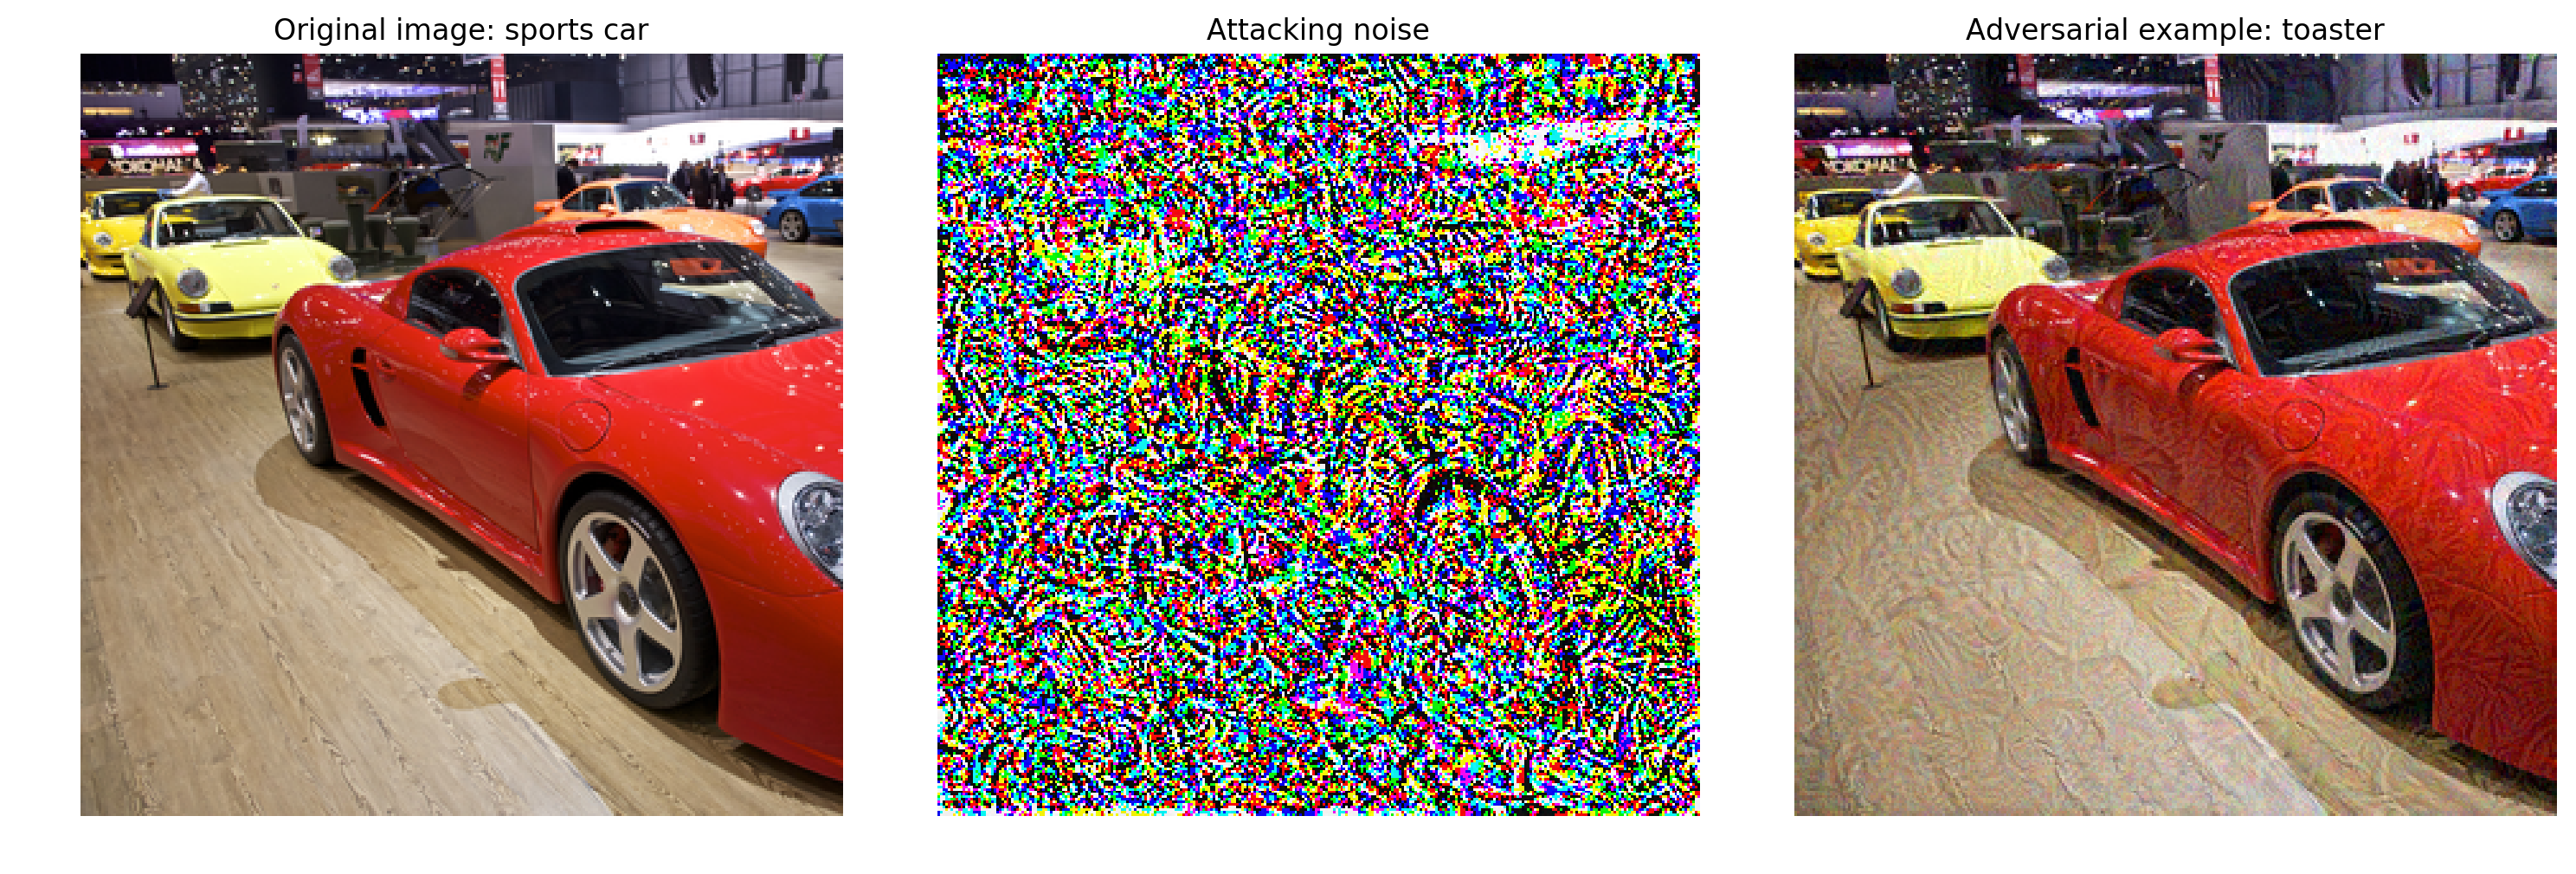

In [12]:
img = load_image('input.png')
adv_img, noise = targeted_attack(img, 859)
draw_result(img, noise, adv_img)